In [1]:
import sys

import gammapy 


loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

In [5]:
scaled_amplitude = Parameter('amplitude',
                             value = 1e-12)
dataset_standard  = Dataset_load.create_asimov(model ='pl' , source = "PKSflare",
                                              parameters = Parameters([scaled_amplitude]))
dataset_asimov  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare",
                                            parameters = Parameters([scaled_amplitude]))

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


In [6]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : 1nZ1RO5N-bkg
  Datasets names            : ['1nZ1RO5N']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    refer

In [7]:
dataset_standard.exposure.plot_interactive()
print(dataset_standard.exposure.unit)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

m2 s


WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (75, 75, 24)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64



<WCSAxes: >

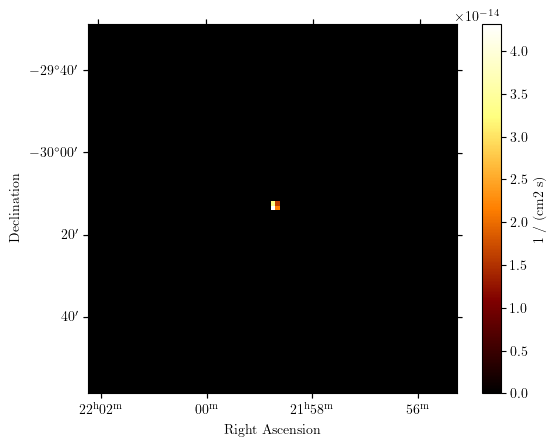

In [8]:
flux = dataset_standard.evaluators[dataset_standard.models.names[0]].compute_flux()
print(flux)
flux.slice_by_idx(dict(energy_true = slice(10,11))).plot(add_cbar = 1)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (75, 75, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxes: >

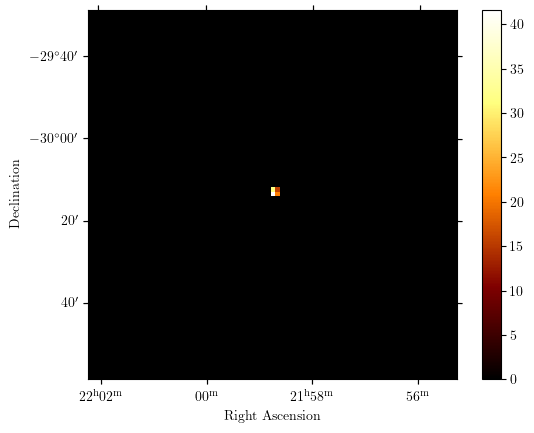

In [9]:
npred = dataset_standard.evaluators[dataset_standard.models.names[0]].apply_exposure(flux)
print(npred)
npred.slice_by_idx(dict(energy_true = slice(10,11))).plot(add_cbar = 1)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (75, 75, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxes: >

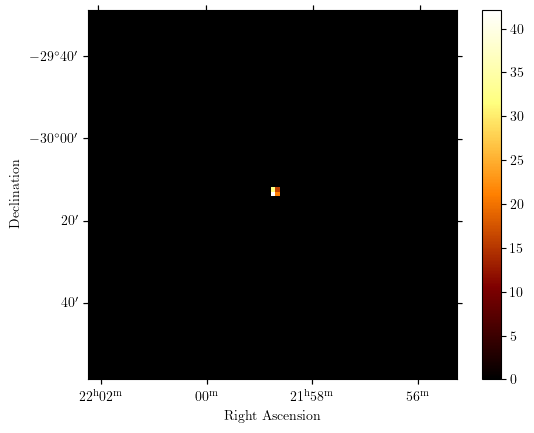

In [10]:
npred_reco = dataset_standard.evaluators[dataset_standard.models.names[0]].apply_edisp(npred)
print(npred_reco)
npred_reco.slice_by_idx(dict(energy = slice(10,11))).plot(add_cbar = 1)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (75, 75, 24)
	ndim  : 3
	unit  : 
	dtype : float32



<WCSAxes: >

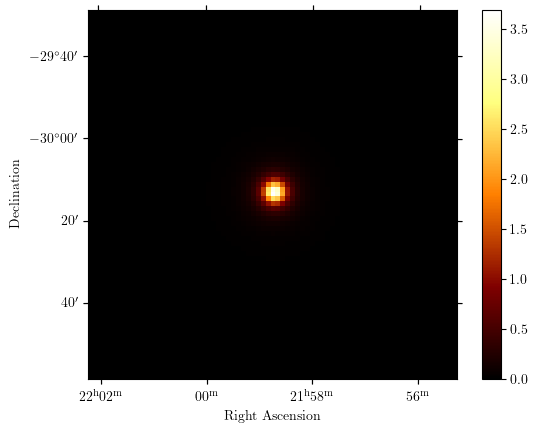

In [11]:
npred_reco_con = dataset_standard.evaluators[dataset_standard.models.names[0]].apply_psf(npred_reco)
print(npred_reco_con)
npred_reco_con.slice_by_idx(dict(energy = slice(10,11))).plot(add_cbar = 1)

## Varying the Exposure

In [36]:
emask = dataset_standard.mask.data.sum(axis=2).sum(axis=1) >0 
true_energy = dataset_standard.exposure.geom.axes[0].center.value[emask]


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.02
tilt_pos = 0.02
tilt_cor = 0

true_energy

array([ 0.36517413,  0.48696753,  0.64938163,  0.86596432,  1.15478198,
        1.53992653,  2.05352503,  2.73841963,  3.65174127,  4.86967525,
        6.49381632,  8.65964323, 11.54781985, 15.39926526, 20.53525026,
       27.38419634, 36.51741273, 48.69675252, 64.93816316, 86.59643234])

In [37]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

In [38]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_pos, 
                        tilt = tilt_pos,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
dataset_pos = sys_d_pos.create_dataset()



In [39]:
print(dataset_pos.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : yc7uPUC0-bkg
  Datasets names            : ['yc7uPUC0']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference    

In [40]:
exposure_pos = dataset_pos.exposure
exposure_neg = dataset_neg.exposure



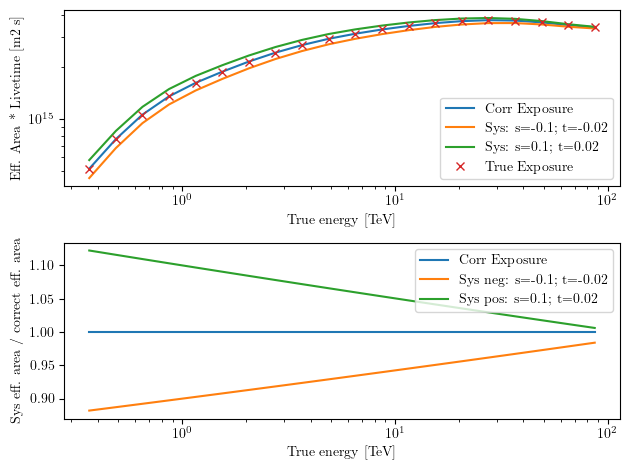

In [41]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_standard.exposure.data.sum(axis=2).sum(axis=1)[emask]
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)[emask]

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, sum_e(exposure_neg.data), 
           label = f'Sys: s={shift_neg:.1}; t={tilt_neg:.1}')
ax[0].plot(true_energy, sum_e(exposure_pos.data), 
           label = f'Sys: s={shift_pos:.1}; t={tilt_pos:.1}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_standard.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
           label = f'Sys neg: s={shift_neg:.1}; t={tilt_neg:.1}')
ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
           label = f'Sys pos: s={shift_pos:.1}; t={tilt_pos:.1}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()
plt.tight_layout()
fig.savefig("plots/1_exposure_example.pdf")

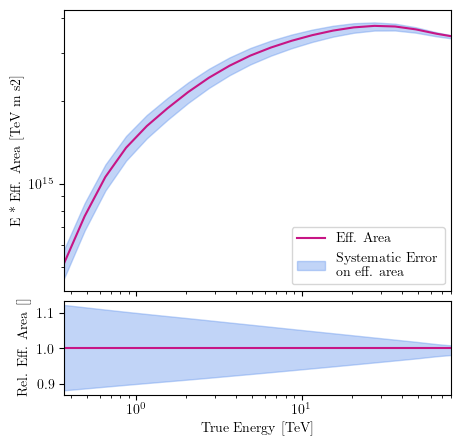

In [42]:

fig,ax = plt.subplots(2,1, sharex = True, height_ratios=[3, 1],
                     figsize = (5,5))

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
energy_power = 1
npred =     sum_e(dataset_cor.npred_signal().data)*true_energy**energy_power
npred_neg = sum_e(dataset_neg.npred_signal().data)*true_energy**energy_power
npred_pos = sum_e(dataset_pos.npred_signal().data)*true_energy**energy_power


ax[0].plot(true_energy, exposure_e, label = "Eff. Area", color = colors[0])
ax[0].fill_between(true_energy, sum_e(exposure_neg.data), sum_e(exposure_pos.data),  label = "Systematic Error \n on eff. area",
                  color = colors[3], alpha = 0.4)

         
ax[0].loglog()
ax[0].legend()
ax[1].set_xlabel("True Energy [TeV]")
ax[0].set_ylabel("E *  Eff. Area [TeV m s2]")
ax[1].set_ylabel("Rel. Eff. Area []")
#ax[0].set_ylim(3e0, 3e2)
ax[0].set_xlim(true_energy[0], 80)


ax[1].plot(true_energy, npred/npred, label = "Rel. Eff Area", color = colors[0])
ax[1].fill_between(true_energy, npred_neg/npred, npred_pos/npred,  label = "Systematic Error \n on eff. area",
                  color = colors[3], alpha = 0.4)
plt.subplots_adjust(wspace=0, hspace=0.05)

#ax[1].legend()
ax[1].set_xscale('log')
fig = plt.gcf()
fig.savefig("plots/1_eff_area.png")

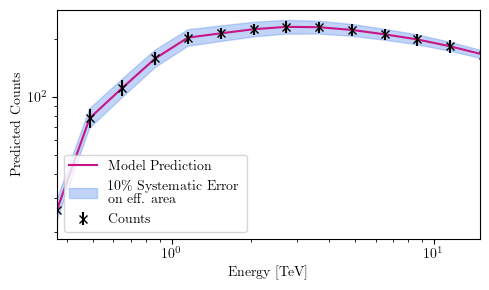

In [43]:

fig,ax = plt.subplots(1,1, sharey = True, figsize = (5,3))

ax = [ax]
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     sum_e(dataset_cor.npred_signal().data)*true_energy
npred_neg = sum_e(dataset_neg.npred_signal().data)*true_energy
npred_pos = sum_e(dataset_pos.npred_signal().data)*true_energy


ax[0].plot(true_energy, npred, label = "Model Prediction", color = colors[0])
ax[0].errorbar(true_energy, npred, yerr=  np.sqrt(npred),  fmt = 'x', label = "Counts",
              color = 'black')
ax[0].fill_between(true_energy, npred_neg, npred_pos,  
                   label = "$10 \%$ Systematic Error \n on eff. area",
                  color = colors[3], alpha = 0.4)
ax[0].loglog()
ax[0].legend(loc = 'lower left')
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Predicted Counts")
'''
if scale >1:
    ax[0].set_ylim(2e3, 9.6e3)
    plt.minorticks_off()
    ax[0].set_yticks([2e3,4e3, 8e3], [ '2000','4000', '8000'])
else:
    ax[0].set_ylim(scale* 2e3, scale* 9.6e3)
    plt.minorticks_off()
    yticks = scale* np.array([2e3,4e3, 8e3])
    yticks_labels = scale * np.array([2000, 4000, 8000])
    yticks_labels = [str(int(y)) for y in yticks_labels]
    ax[0].set_yticks(yticks, yticks_labels)
'''    
ax[0].set_xlim(true_energy[0], 15)
plt.tight_layout()

fig.savefig("plots/1_counts_single.png")

<Figure size 640x480 with 0 Axes>

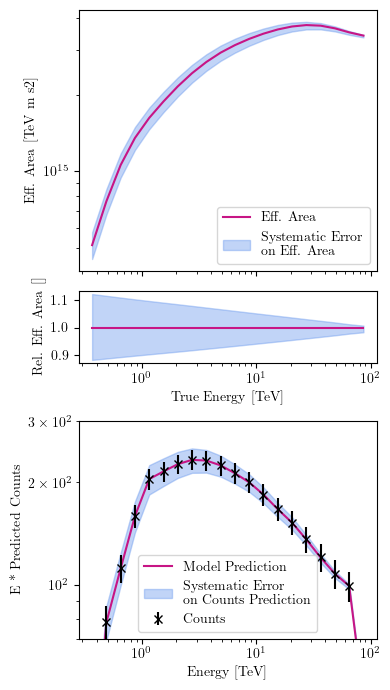

In [90]:
import matplotlib.gridspec as gridspec
plt.subplots_adjust(hspace=0.0)
#make outer gridspec
fig = plt.figure(figsize = (4,7))
outer = gridspec.GridSpec(2, 1, height_ratios = [3, 4]) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .4,
                                      height_ratios = [1, 3])


#fig,ax = plt.subplots(3,1, height_ratios=[3,1, 3],
#                     figsize = (4,7))

ax_exp = plt.subplot(gs1[0])
ax_rel = plt.subplot(gs2[0])
ax_npred =  plt.subplot(gs2[1])

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
energy_power = 1
npred =     sum_e(dataset_cor.npred_signal().data)*true_energy**energy_power
npred_neg = sum_e(dataset_neg.npred_signal().data)*true_energy**energy_power
npred_pos = sum_e(dataset_pos.npred_signal().data)*true_energy**energy_power

# npred 
ax_npred.plot(true_energy, npred, label = "Model Prediction", color = colors[0])
ax_npred.fill_between(true_energy, npred_neg, npred_pos,
                   label = "Systematic Error \non Counts Prediction",
                  color = colors[3], alpha = 0.4)
ax_npred.errorbar(true_energy, npred, yerr= np.sqrt(npred),  fmt = 'x', label = "Counts",
              color = 'black')
         



# exp
energy_power = 0
exposure_ee = exposure_e *true_energy**energy_power
exposure_ee_neg = sum_e(exposure_neg.data) *true_energy**energy_power
exposure_ee_pos = sum_e(exposure_pos.data) *true_energy**energy_power

ax_exp.plot(true_energy, exposure_ee, label = "Eff. Area", color = colors[0])
ax_exp.fill_between(true_energy, exposure_ee_neg, exposure_ee_pos,
                   label = "Systematic Error \n on Eff. Area",
                  color = colors[3], alpha = 0.4)


# rel
ax_rel.plot(true_energy, npred/npred, label = "Rel. Eff Area", color = colors[0])
ax_rel.fill_between(true_energy, npred_neg/npred, npred_pos/npred,  label = "Systematic Error \n on Eff. Area",
                  color = colors[3], alpha = 0.4)

#settings
ax_npred.legend()
ax_exp.legend()


plt.subplots_adjust(wspace=0, hspace=0.02)
ax_exp.set_yscale('log')
ax_npred.set_yscale('log')
ax_rel.set_yscale('linear')


ax_rel.set_xlabel("True Energy [TeV]")
ax_npred.set_xlabel("Energy [TeV]")

ax_exp.set_ylabel(" Eff. Area [TeV m s2]")
ax_rel.set_ylabel("Rel. Eff. Area []")
ax_npred.set_ylabel("E * Predicted Counts")
ax = [ax_exp, ax_rel, ax_npred]
for a in ax:
    a.set_xscale('log')
ax_exp.set_xticklabels([])
#ax_exp.xaxis.tick_top()
    
ax_npred.set_ylim(7e1, 3e2)
plt.tight_layout()

#plt.subplots_adjust(left=0.2,
#                    bottom=0.1,
#                    right=0.95,
#                    top=0.9,
#                    wspace=0.1,
#                    hspace=0.15)

fig.savefig("plots/1_eff_area.pdf")
fig.savefig("plots/1_eff_area.png")


In [45]:
Source  = dataset_standard.models.names[0]
print(dataset_standard.models[Source])

SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         




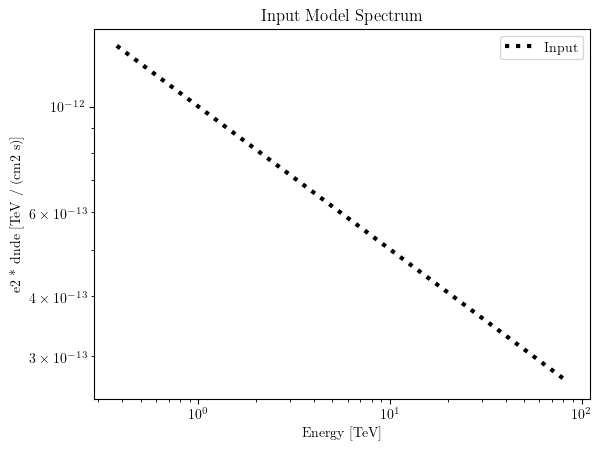

In [46]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_standard.models[Source].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

<WCSAxes: >

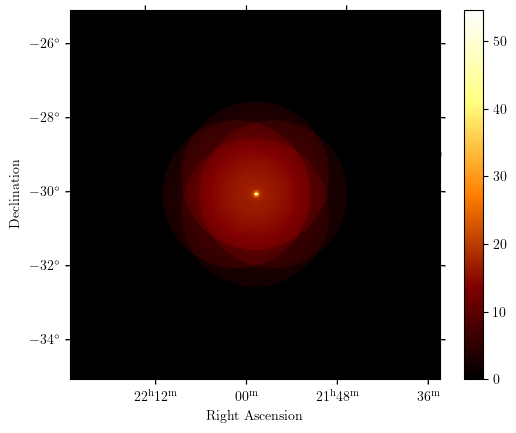

In [47]:
dataset_cor.counts.sum_over_axes().plot(add_cbar = 1)

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

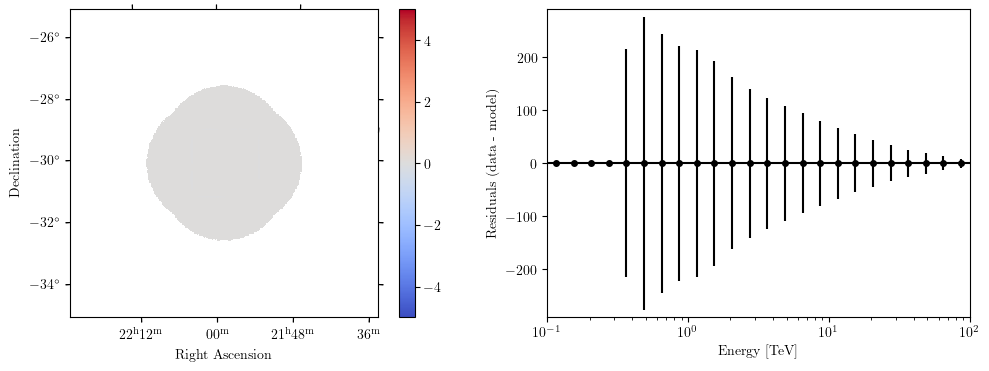

In [48]:
dataset_cor.plot_residuals()

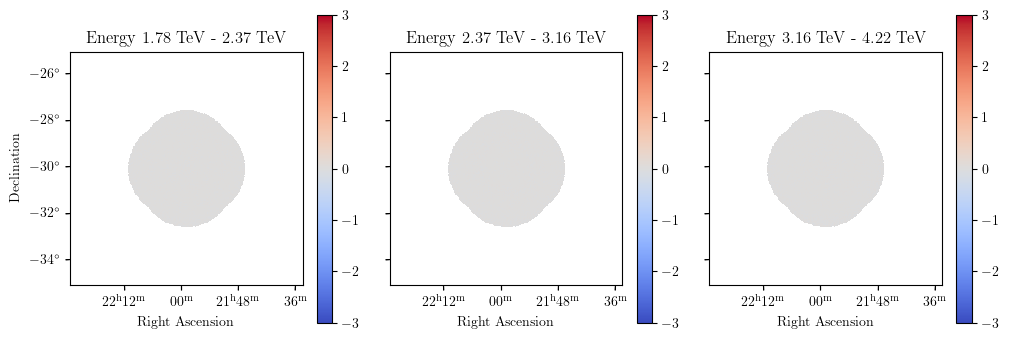

In [49]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
vmax = 3
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

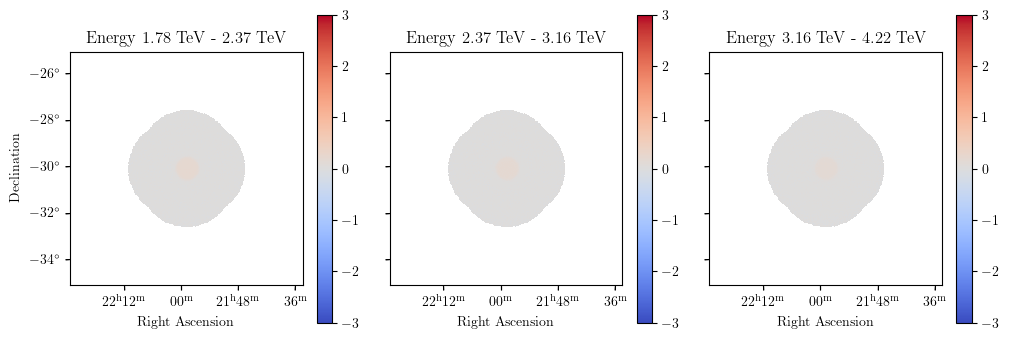

In [26]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

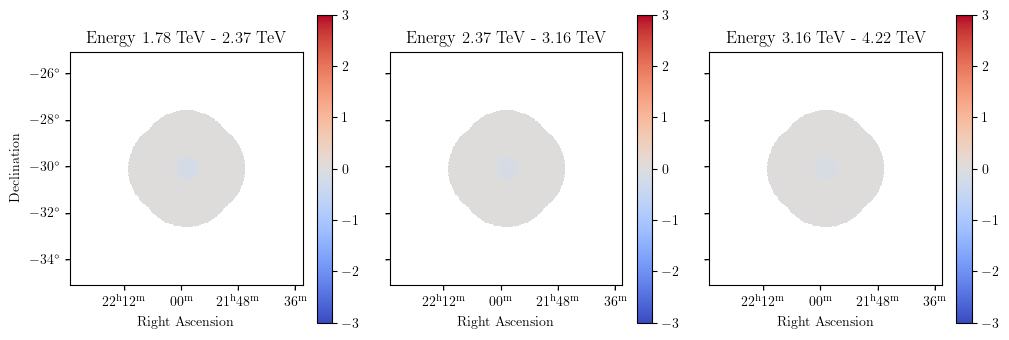

In [27]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

In [28]:
%%time
print('cor')
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
print('neg')
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
print('pos')
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])

cor
neg
pos
CPU times: user 1min 30s, sys: 27.9 s, total: 1min 58s
Wall time: 1min 58s


In [29]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("best fit amplitude")
amplitudes = []
m = dataset_standard.models[Source]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[Source]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices = []
m = dataset_standard.models[Source]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[Source]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_standard.background_model.parameters['norm'].value 
error = dataset_standard.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
    
    
print("Best Fit bkg Tilt")
tilts = []
value = dataset_standard.background_model.parameters['tilt'].value 
error = dataset_standard.background_model.parameters['tilt'].error
tilts.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['tilt'].value 
    error = d.background_model.parameters['tilt'].error
    print(f'{value} pm {error}')
    tilts.append((value, error))
    
    
with open('data/1_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
with open('data/1_tilts.yaml', 'w') as file:
    documents = yaml.dump(tilts, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

best fit amplitude
====
Input
1e-12 pm 0.0
====
1.1113314638891421e-12 pm 5.6200259291900434e-14
1.0002114904783931e-12 pm 5.058564503908816e-14
9.09612949917694e-13 pm 4.600304584288399e-14

best fit Index
====
Input
2.3 pm 0.0
====
2.318985908760062 pm 0.04633379532491738
2.2990268468181827 pm 0.04633670302806239
2.2790073991626913 pm 0.04633386276650351

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.999999785206054 pm 0.0015603967231093824
1.0000002675477486 pm 0.0015603947781809683
0.9999995744544345 pm 0.0015603960659339427
Best Fit bkg Tilt
====
Input
0.0 pm 0
====
0.0 pm 0.0
0.0 pm 0.0
0.0 pm 0.0


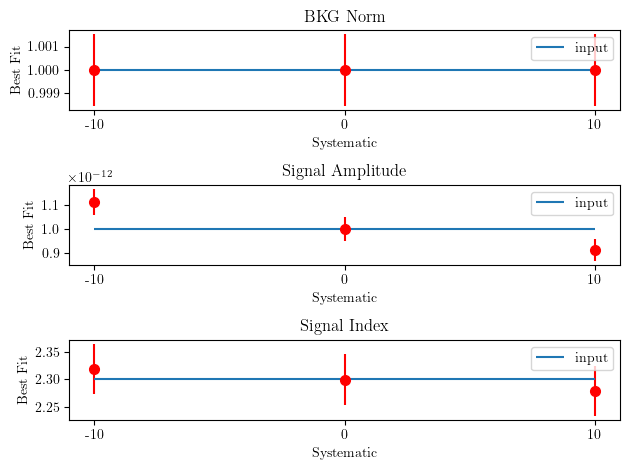

In [30]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_standard.pdf")   


In [31]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : 1nZ1RO5N-bkg
  Datasets names            : ['1nZ1RO5N']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    refer

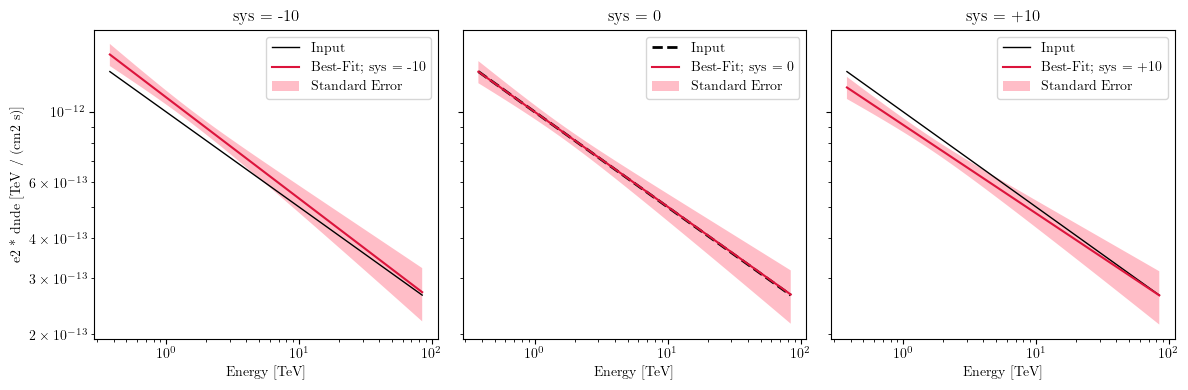

In [32]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard_all.pdf")

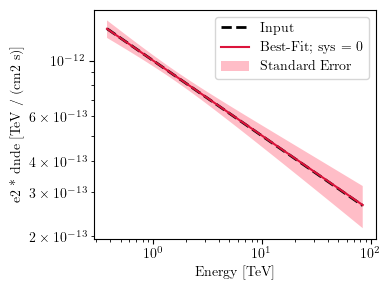

In [33]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))

dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =axs, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")


dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

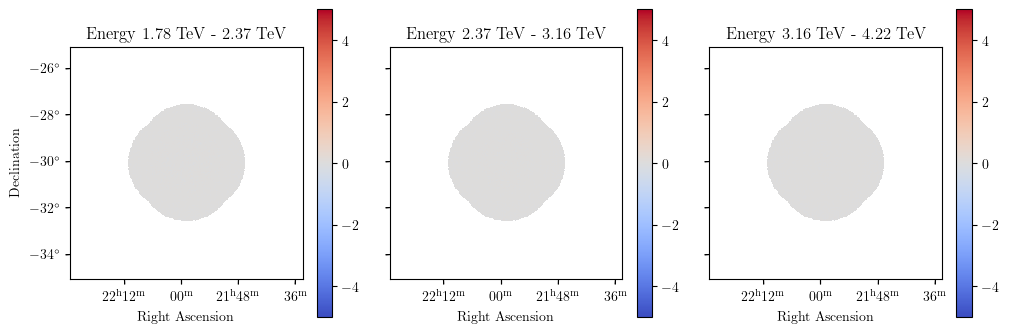

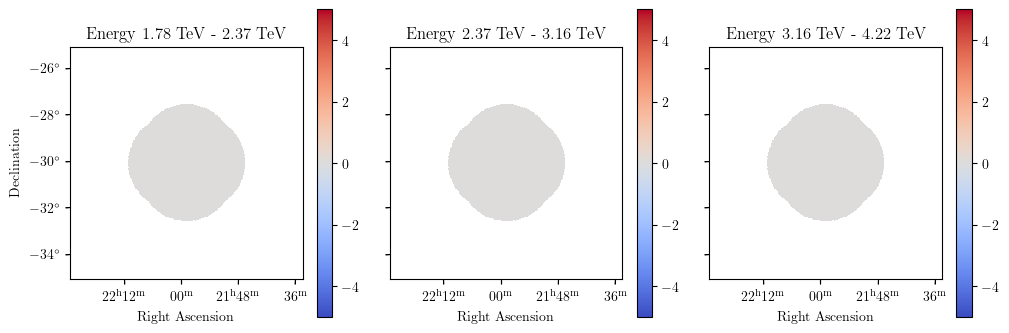

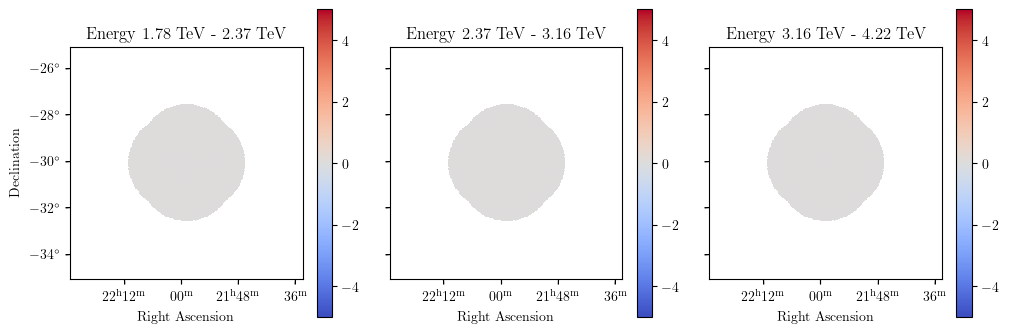

In [34]:

result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);